# Testing regularization of likelihood functions

In [1]:
%pylab inline
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"]="0"
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import tensorflow as tf


In [3]:
sys.path.append('../../utils/flowpm/')
import tfpmconfig, tfpm
import tfpmfuncs as tfpf
import tfpmfuncs
sys.path.append('../../utils/')
import tools


In [4]:
from matplotlib.colors import LogNorm

In [5]:
import tensorflow_probability as tfp
tfd = tfp.distributions

import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import add_arg_scope
import tensorflow_hub as hub


In [6]:
from time import time

In [7]:
bs, nc = 100, 32
config = tfpmconfig.Config(bs=bs, nc=nc)
kmesh = sum(kk**2 for kk in config['kvec'])**0.5
priorwt = config['ipklin'](kmesh) * config['boxsize'] ** -3

# path = '../../data/toy/L0100_N0032/S{:04d}/'
path = '../../../galmodel/data/toy/L0100_N0032/S{:04d}/'
seed = 0 
s = np.load(path.format(seed) + 's.npy')
d = np.load(path.format(seed) + 'd.npy')
p = np.load(path.format(seed) + 'p.npy')

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  This is separate from the ipykernel package so we can avoid doing imports until


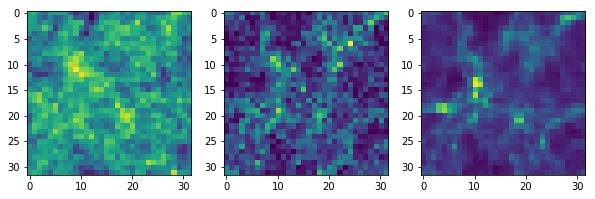

In [8]:
plt.figure(figsize = (10, 4))
ax = plt.subplot(1, 3, 1)
plt.imshow(s.sum(axis=0))
ax = plt.subplot(1, 3, 2)
plt.imshow(p.sum(axis=0))
ax = plt.subplot(1, 3, 3)
plt.imshow(d.sum(axis=0))

In [9]:
lins, fins, finsample = [], [], []
for seed in range(1000):
    lins.append(np.load(path.format(seed)+'s.npy'))
    fins.append(np.load(path.format(seed)+'d.npy'))
    finsample.append(np.load(path.format(seed)+'p.npy'))

lins = np.array(lins)
fins = np.array(fins)
finsample = np.array(finsample)

In [10]:
lins.shape, fins.shape, finsample.shape

((1000, 32, 32, 32), (1000, 32, 32, 32), (1000, 32, 32, 32))

In [11]:
inits = lins.copy()

In [12]:

def evolvefinal( xinit):
    tf.reset_default_graph()

    xrecon = tf.get_variable('xrecon',
                             initializer=xinit, 
                             trainable=True)

    icstate = tfpm.lptinit(xrecon, config, name='icstate')
    fnstate = tfpm.nbody(icstate, config, verbose=False, name='fnstate')
    final = tf.zeros_like(xrecon)
    final = tfpf.cic_paint(final, fnstate[0], boxsize=config['boxsize'], name='final')
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sample = sess.run(final)
    return sample



# Train model on final field

In [ ]:
# ###If reading a saved module, uncomment this

# tf.reset_default_graph()
# modname = './modules/densemoduleza3dsamplefin2//'
# module = hub.Module(modname, trainable=False)

# sample = module({'features':fins, 'labels':finsample}, as_dict=True)['sample']
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     learnfin = sess.run(sample)


##Else run the following cell to train the network

In [24]:


tf.reset_default_graph()


nfilter = 16
def module_fn():
    '''Define network here'''
    x = tf.placeholder(tf.float32, shape=[None, nc, nc, nc], name='input')
    y = tf.placeholder(tf.float32, shape=[None, nc, nc, nc], name='output')

    reg = tf.contrib.layers.l2_regularizer(0.00)

    xx = tf.expand_dims(x, -1)
    net = tf.layers.conv3d(xx,nfilter, 5, activation=tf.nn.leaky_relu, kernel_regularizer=reg,padding='same')
    
    net = tf.nn.leaky_relu(net)
    subnet = tf.layers.conv3d(net,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = net + tf.layers.conv3d(subnet,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = tf.layers.conv3d(net,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = net + tf.layers.conv3d(subnet,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = tf.layers.conv3d(net,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = net + tf.layers.conv3d(subnet,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = tf.layers.conv3d(net,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = net + tf.layers.conv3d(subnet,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = tf.nn.dropout(net, 0.95)

    net = tf.layers.conv3d(net,1, 3, activation=tf.nn.leaky_relu, kernel_regularizer=reg,padding='same')
    net = tf.layers.conv3d(net,1, 1, kernel_regularizer=reg,padding='same')

    lognet = tf.layers.conv3d(net, 1, 1, kernel_regularizer=reg,padding='same', 
                              name='lograte')    
    net = tf.nn.softplus(lognet)
    net= tf.squeeze(net)
    net = tf.identity(net, name='rate')
    mixture_dist = tfd.Poisson(rate=net)
    sample = tf.squeeze(mixture_dist.sample())
#     loglik = mixture_dist.log_prob(tf.expand_dims(y, -1))
    loglik = mixture_dist.log_prob(y)
    
    
    hub.add_signature(inputs={'features':x, 'labels':y}, 
#                           outputs={'sample':sample, 'loglikelihood':loglik, 'loc':loc, 
#                                   'scale':scale, 'logits':logits})
                        outputs={'sample':sample, 'loglikelihood':loglik, 'lograte':lognet, 'rate':net})
    
#####                                                                                                                                                                                                                                                                                     


spec = hub.create_module_spec(module_fn)
module = hub.Module(spec, trainable=True)


xx = tf.placeholder(tf.float32, shape=[None, nc, nc, nc], name='input')
yy = tf.placeholder(tf.float32, shape=[None, nc, nc, nc], name='input')
rate = module({'features':xx, 'labels':yy}, as_dict=True)['rate']
loglik = module({'features':xx, 'labels':yy}, as_dict=True)['loglikelihood']
sample = module({'features':xx, 'labels':yy}, as_dict=True)['sample']
loss = -loglik #tf.reduce_sum(tf.square(tf.add(rate, -yy)), axis=-1)
loss = tf.reduce_mean(loss)

lr = tf.placeholder(tf.float32)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
losses =[]

data_size = 800
batch_size = 32

for i in range(500):
    inds = np.random.randint(0, data_size, batch_size)
    x = fins[inds]
    y = finsample[inds]
    l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.001})
    if np.isnan(l): 
        print(i, l)
        break
    losses.append( l)   
    if i%300 ==0: print(l)
# for i in range(500):
#     inds = np.random.randint(0, data_size, batch_size)
#     x = fins[inds]
#     y = finsample[inds]
#     l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.001})
#     if np.isnan(l): 
#         print(i, l)
#         break
#     losses.append(l)
#     if i%300 ==0: print(l)
# for i in range(500):
#     inds = np.random.randint(0, data_size, batch_size)
#     x = fins[inds]
#     y = finsample[inds]
#     l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.0005})
#     if np.isnan(l): 
#         print(i, l)
#         break
#     losses.append(l)
#     if i%300 ==0: print(l)
        
print('Done', l)
if ~np.isnan(l):
    learnfin = sess.run(sample, feed_dict={xx:fins, yy:y})
    learnfinrate = sess.run(rate, feed_dict={xx:fins, yy:y})
    
    
plot(losses[1:])
plt.yscale('log')
plt.xscale('log')
plt.show()



INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
0.79242826
0.29438898
Done 0.29359156


In [ ]:
# %%bash
# ls modules/
# # rm -r ./modules/densemoduleza3dsamplefin
# # 
# # module.export('./modules/densemoduleza3dsamplefin2', sess)


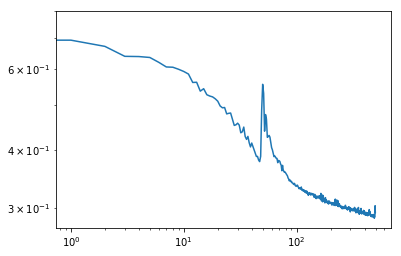

Text(0.5, 1.0, 'Output Learnt')

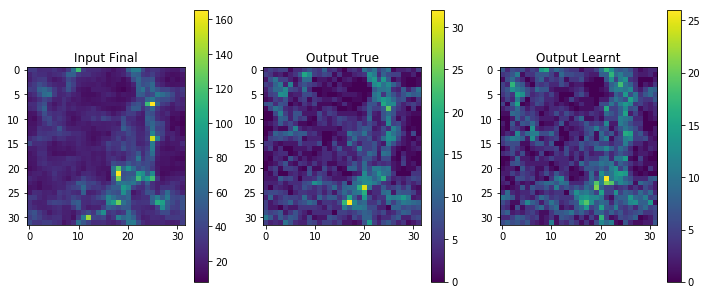

In [25]:

fig, ax = plt.subplots(1, 3, figsize = (12, 5))
ii = 90
axis = ax
im = axis[0].imshow(fins[ii].sum(axis=0))
colorbar(im, ax=axis[0])
axis[0].set_title('Input Final')
im = axis[1].imshow(finsample[ii].sum(axis=0))
colorbar(im, ax=axis[1])
axis[1].set_title('Output True')
im = axis[2].imshow(learnfin[ii].sum(axis=0))
colorbar(im, ax=axis[2])
axis[2].set_title('Output Learnt')


INFO:tensorflow:Exported TF-Hub module to: ./modules/densemoduleza3dsamplefin2


### Reconstruct with fin model

In [61]:
testid  = 100


In [29]:
kmesh = sum(kk**2 for kk in config['kvec'])**0.5
priorwt = config['ipklin'](kmesh) * config['boxsize'] ** -3

def doreconfin(yy, xinit, modname, useprior=True, niter=5000, lr=0.001, sampleonly=False):
    tf.reset_default_graph()
    module = hub.Module(modname, trainable=False)

    xrecon = tf.get_variable('xrecon',
                             initializer=xinit, 
                             trainable=True)

    icstate = tfpm.lptinit(xrecon, config, name='icstate')
    fnstate = tfpm.nbody(icstate, config, verbose=False, name='fnstate')
    final = tf.zeros_like(xrecon)
    final = tfpf.cic_paint(final, fnstate[0], boxsize=config['boxsize'], name='final')

    sample = module({'features':tf.expand_dims(final, 0), 'labels':yy}, as_dict=True)['sample']
    if sampleonly: 
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            sample = sess.run(sample)
        return sample
    
        
    loglik = module({'features':tf.expand_dims(final, 0), 'labels':yy}, as_dict=True)['loglikelihood']
    loglik = -tf.reduce_sum(loglik, axis=(1, 2, 3))
    
    xreconk = tfpmfuncs.r2c3d(xrecon)
    priormesh = tf.square(tf.cast(tf.abs(xreconk), tf.float32))
    prior = tf.reduce_sum(tf.multiply(priormesh, 1/priorwt), axis=(0, 1, 2))
    prior = tf.multiply(prior, 1/nc, name='prior')
    print(loglik, prior)

    if useprior: loss = tf.add(loglik, prior)
    else: loss = loglik
#   
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
    opt_op = optimizer.minimize(loss, var_list=[xrecon])


    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        xinit = sess.run(xrecon)
        losses = []
        priors = []
        for it in range(niter+1):
            _, l, p = sess.run([opt_op, loss, prior])
            if it%300==0: print(it, l[0])
            losses.append(l)
            priors.append(p)
        xfin = sess.run(xrecon)
        
    return xfin, losses, priors

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  """Entry point for launching an IPython kernel.


In [62]:
tf.reset_default_graph()
modname = './modules/densemoduleza3dsamplefin2/'
xreconsfin = []
losses = []
priors = []
xinit = []

nstart = 1

np.random.seed(100)
yy = np.array([finsample[testid].copy() for j in range(nstart)])
yy = yy
xi = 1*randn( nc, nc, nc)
xi = xi.astype('float32')
#     xi = xreconsfin[0].copy()

recons = doreconfin(yy, xi, modname, useprior=True, niter=1000, lr=0.01)
xrecon = np.squeeze(recons[0])
xreconsfin.append(xrecon)
losses.append(np.squeeze(recons[1]))
priors.append(np.squeeze(recons[2]))
xinit.append(xi)



INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Tensor("Neg:0", shape=(1,), dtype=float32) Tensor("prior:0", shape=(), dtype=float32)
0 17803.168
300 8681.832
600 8341.525
900 8173.346


In [24]:
###Maybe save reconstrunction here if not interested in doing it every time
# np.save('./xreconfindenseza3dsample', xreconsfin[0])
# xreconsfin = [np.load('./xreconfindenseza3dsample.npy')]

Text(0.5, 1.0, 'Difference')

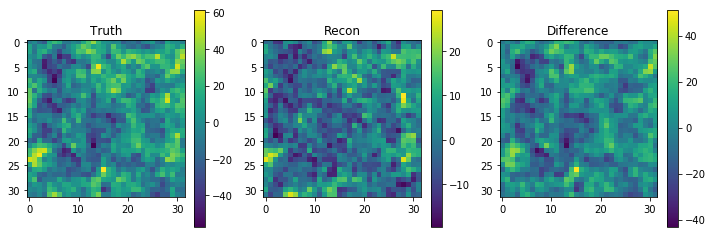

In [63]:
fig, axar = plt.subplots(1,3,figsize=(12, 4))

ax = axar
im = ax[0].imshow(inits[testid].sum(axis=0))
colorbar(im, ax=ax[0])
ax[0].set_title('Truth')
im = ax[1].imshow(xreconsfin[-1].sum(axis=0))
colorbar(im, ax=ax[1])
ax[1].set_title('Recon')
im = ax[2].imshow((inits[testid]-xreconsfin[-1]).sum(axis=0))
colorbar(im, ax=ax[2])
ax[2].set_title('Difference')


In [439]:
# np.save('./xreconfintruedenseza3dsample', xreconsfintrue[0])
# xreconsfintrue = [np.load('./xreconfintruedenseza3dsample.npy')]

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


(0, 1)

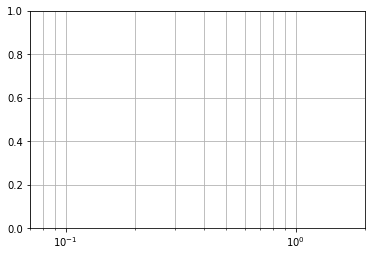

In [94]:
kk, p1 = tools.power(inits[testid], boxsize=bs)
kk, p2 = tools.power(xreconsfin[-1], boxsize=bs)
kk, p12 = tools.power(inits[testid], xreconsfin[-1], boxsize=bs)

plt.plot(kk, p12/(p1*p2)**0.5)
plt.xscale('log')
plt.grid(which='both')
plt.ylim(0, 1)

In [100]:
tf.reset_default_graph()
modname = './modules/densemoduleza3dsamplefin2/'
samplexreconsfin = doreconfin(np.expand_dims(xreconsfin[-1], axis=0)*0, xreconsfin[-1], modname=modname,  sampleonly=True)

tmp = inits[testid].copy()
samplelearnfin = doreconfin(np.expand_dims(tmp, 0)*0, tmp , modname=modname, sampleonly=True)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


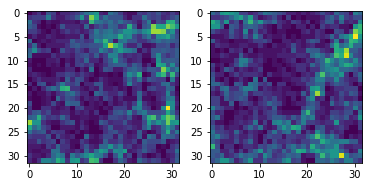

In [96]:
ax = plt.subplot(1, 2, 1)
plt.imshow(finsample[testid].sum(axis=0))
ax = plt.subplot(1, 2, 2)
plt.imshow(samplexreconsfin.sum(axis=0))

# Specnorm it!


In [40]:
import sys
sys.path.append('../../utils/')
import tfops, layers
from layers import SpecDenseLayer
from tfops import specnormconv3d as specconv3d


In [ ]:
###If already have the trained network, read from here

# tf.reset_default_graph()
# modname = './modules/specdensemoduleza3dsamplefin2///'
# module = hub.Module(modname, trainable=False)
# sample = module({'features':fins, 'labels':finsample}, as_dict=True)['sample']
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     learnspecfin = sess.run(sample)


In [ ]:


#####                                                                                                                                                                                                                                                                                     

tf.reset_default_graph()

nfilter = 32
num_iters = 1
normwt = 0.9

def module_fn():
    '''Define network here'''
    x = tf.placeholder(tf.float32, shape=[None, nc, nc, nc], name='input')
    y = tf.placeholder(tf.float32, shape=[None, nc, nc, nc], name='output')

    xx = tf.expand_dims(x, -1)

#     net = specconv3d(xx, nfilter, 5, num_iters=num_iters, normwt=normwt)
#     net = activation=tf.nn.leaky_relu(net)
#     net = tf.nn.leaky_relu(net)
    
    net = xx
    
    subnet = specconv3d(net, nfilter, 3, name='l11', num_iters=num_iters, normwt=normwt)
    net = net + specconv3d(subnet,1, 3, name='l12', num_iters=num_iters, normwt=normwt)
#     net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = specconv3d(net, nfilter, 3, name='l21', num_iters=num_iters, normwt=normwt)
    net = net + specconv3d(subnet,1, 3, name='l22', num_iters=num_iters, normwt=normwt)
#     net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = specconv3d(net, nfilter, 3, name='l31', num_iters=num_iters, normwt=normwt)
    net = net + specconv3d(subnet,1, 3, name='l32', num_iters=num_iters, normwt=normwt)
#     net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = specconv3d(net, nfilter, 3, name='l41', num_iters=num_iters, normwt=normwt)
    net = net + specconv3d(subnet,1, 3, name='l42', num_iters=num_iters, normwt=normwt)
#     net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = specconv3d(net, nfilter, 3, name='l51', num_iters=num_iters, normwt=normwt)
    net = net + specconv3d(subnet,1, 3, name='l52', num_iters=num_iters, normwt=normwt)
#     net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = specconv3d(net, nfilter, 3, name='l61', num_iters=num_iters, normwt=normwt)
    net = net + specconv3d(subnet,1, 3, name='l62', num_iters=num_iters, normwt=normwt)
#     net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = specconv3d(net, nfilter, 3, name='l71', num_iters=num_iters, normwt=normwt)
    net = net + specconv3d(subnet,1, 3, name='l72', num_iters=num_iters, normwt=normwt)
#     lognet = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = specconv3d(net, nfilter, 3, name='l81', num_iters=num_iters, normwt=normwt)
    net = net + specconv3d(subnet,1, 3, name='l82', num_iters=num_iters, normwt=normwt)
#     lognet = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = specconv3d(net, nfilter, 3, name='l91', num_iters=num_iters, normwt=normwt)
    net = net + specconv3d(subnet,1, 3, name='l92', num_iters=num_iters, normwt=normwt)
#     lognet = tf.nn.dropout(net, 0.95)

#     net = tf.nn.leaky_relu(net)
#     lognet = specconv3d(net, 1, 1, name='lognet', num_iters=num_iters, normwt=normwt)
    
    lognet = net
    rate = tf.nn.softplus(lognet)
    rate = tf.squeeze(rate)
    rate = tf.identity(rate, name='rate')
    mixture_dist = tfd.Poisson(rate=rate)
    sample = tf.squeeze(mixture_dist.sample())
#     loglik = mixture_dist.log_prob(tf.expand_dims(y, -1))
    loglik = mixture_dist.log_prob(y)
    
    
    hub.add_signature(inputs={'features':x, 'labels':y}, 
#                           outputs={'sample':sample, 'loglikelihood':loglik, 'loc':loc, 
#                                   'scale':scale, 'logits':logits})
                        outputs={'sample':sample, 'loglikelihood':loglik, 'lograte':lognet, 'rate':rate})
    
    
#####                                                                                                                                                                                                                                                                                     


spec = hub.create_module_spec(module_fn)
module = hub.Module(spec, trainable=True)


xx = tf.placeholder(tf.float32, shape=[None, nc, nc, nc], name='input')
yy = tf.placeholder(tf.float32, shape=[None, nc, nc, nc], name='input')
rate = module({'features':xx, 'labels':yy}, as_dict=True)['rate']
loglik = module({'features':xx, 'labels':yy}, as_dict=True)['loglikelihood']
sample = module({'features':xx, 'labels':yy}, as_dict=True)['sample']
loss = loglik#tf.reduce_sum(tf.square(tf.add(rate, -yy)), axis=-1)
loss = -tf.reduce_mean(loss)

lr = tf.placeholder(tf.float32)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
losses =[]



data_size = 800
batch_size = 32

for i in range(500):
    inds = np.random.randint(0, data_size, batch_size)
    x = fins[inds]
    y = finsample[inds]
    l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.01})
    if np.isnan(l): 
        print(i, l)
        break
    losses.append(l)
    if i%300 ==0: print(l)
# for i in range(500):
#     inds = np.random.randint(0, data_size, batch_size)
#     x = fins[inds]
#     y = finsample[inds]
#     l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.0005})
#     if np.isnan(l): 
#         print(i, l)
#         break
#     losses.append(l)
#     if i%300 ==0: print(l)
# for i in range(500):
#     inds = np.random.randint(0, data_size, batch_size)
#     x = fins[inds]
#     y = finsample[inds]
#     l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.0001})
#     if np.isnan(l): print(i, l)
#     losses.append(l)
#     if i%300 ==0: print(l)

        
        
if not np.isnan(l):
    learnspecfin = sess.run(sample, feed_dict={xx:fins, yy:y})
    learnspecfinrate = sess.run(rate, feed_dict={xx:fins, yy:y})


../../utils/tfops.py:36: UserWarning: Setting update_collection to None will make u being updated every W execution. This maybe undesirable. Please consider using a update collection instead.
  warnings.warn('Setting update_collection to None will make u being updated every W execution. This maybe undesirable'
../../utils/tfops.py:36: UserWarning: Setting update_collection to None will make u being updated every W execution. This maybe undesirable. Please consider using a update collection instead.
  warnings.warn('Setting update_collection to None will make u being updated every W execution. This maybe undesirable'
../../utils/tfops.py:36: UserWarning: Setting update_collection to None will make u being updated every W execution. This maybe undesirable. Please consider using a update collection instead.
  warnings.warn('Setting update_collection to None will make u being updated every W execution. This maybe undesirable'
../../utils/tfops.py:36: UserWarning: Setting update_collection 

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


3.5738792
2 nan


In [ ]:
plot(losses[1:])
plt.yscale('log')
plt.xscale('log')
plt.show()


In [ ]:

def thisplot(axis, mat, title):
    
    im = axis.imshow(mat[...].sum(axis=0))
    plt.colorbar(im, ax=axis)
    axis.set_title(title)
    

ii = 0 

fig, ax = plt.subplots(1, 4, figsize = (18, 4))

axis, mat, title = ax[0], fins[ii], 'True Input'
thisplot(axis, mat, title)

axis, mat, title = ax[1], finsample[ii], 'True Output'
thisplot(axis, mat, title)

axis, mat, title = ax[2], learnfin[ii], 'Learn Vanilla'
thisplot(axis, mat, title)

axis, mat, title = ax[3], learnspecfin[ii], 'Learn SpecNorm'
thisplot(axis, mat, title)



In [ ]:
%%bash
ls ./modules/
rm -r ./modules/specdensemoduleza3dsamplefin2

# module.export('./modules/specdensemoduleza3dsamplefin2', sess)


/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


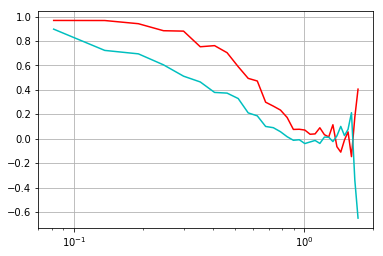

In [70]:
ii = 1
kk, p1 = tools.power(finsample[ii], boxsize=bs)
kk, p2 = tools.power(learnfin[ii], boxsize=bs)
kk, p5 = tools.power(learnspecfin[ii], boxsize=bs)
kk, p12 = tools.power(finsample[ii], learnfin[ii], boxsize=bs)
kk, p15 = tools.power(finsample[ii], learnspecfin[ii], boxsize=bs)

plt.plot(kk, p12/(p1*p2)**.5, 'r-', label='Learn Final')
plt.plot(kk, p15/(p1*p5)**.5, 'c-', label='Learn Spec Final')
plt.xscale('log')
plt.grid()

## recon again

In [72]:
tf.reset_default_graph()
modname = './modules/specdensemoduleza3dsamplefin2/'
xreconsspecfin = []
losses = []
priors = []
xinit = []

nstart = 1


np.random.seed(100)
yy = np.array([finsample[testid].copy() for j in range(nstart)])
yy = yy
xi = 1*randn( nc, nc, nc)
xi = xi.astype('float32')

recons = doreconfin(yy, xi, modname, useprior=True, niter=1000, lr=0.01)
xrecon = np.squeeze(recons[0])
#     recons = doreconfin(yy, xrecon, modname, useprior=True, niter=3000, lr=0.005)
xreconsspecfin.append(xrecon)
losses.append(np.squeeze(recons[1]))
priors.append(np.squeeze(recons[2]))
xinit.append(xi)



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Tensor("Neg:0", shape=(1,), dtype=float32) Tensor("prior:0", shape=(), dtype=float32)
0 16902.48
300 13298.565
600 12145.441
900 11554.397


In [157]:
# np.save('./xreconfinspecdenseza3dsample', xreconsspecfin[0])
# # xreconsspecfin = [np.load('./xreconfinspecdenseza3dsample.npy')]

In [73]:
modname = './modules/specdensemoduleza3dsamplefin2/'
samplexreconsspecfin = doreconfin(np.expand_dims(xreconsspecfin[0], 0)*0, 
                               xreconsspecfin[0], modname=modname, sampleonly=True)

tmp = inits[testid].copy()
samplelearnspecfin = doreconfin(np.expand_dims(tmp, 0)*0, tmp , modname=modname, sampleonly=True)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


## Compare recon

In [74]:

finalxreconsfin = evolvefinal(xreconsfin[0])
finalxreconsspecfin = evolvefinal(xreconsspecfin[0])

In [82]:
truth = lins[testid]
final = fins[testid]
data = finsample[testid]

Text(0.5, 1.0, 'PM + Spec Norm')

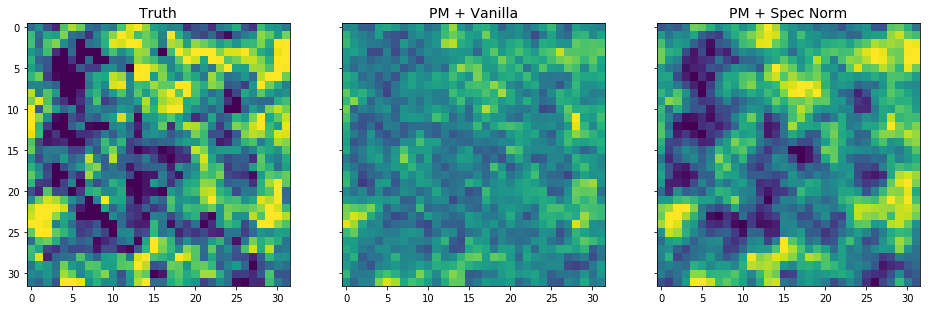

In [76]:
vmin = -30 
vmax = 30

fig, ax = plt.subplots(1, 3, figsize = (16, 5), sharex=True, sharey=True)
fsize = 14
ax[0].imshow(truth.sum(axis=0), vmin=vmin, vmax=vmax)
ax[0].set_title('Truth', fontsize=fsize)
ax[1].imshow(xreconsfin[0].sum(axis=0), vmin=vmin, vmax=vmax)
ax[1].set_title('PM + Vanilla', fontsize=fsize)
ax[2].imshow(xreconsspecfin[0].sum(axis=0), vmin=vmin, vmax=vmax)
ax[2].set_title('PM + Spec Norm', fontsize=fsize)


Text(0.5, 1.0, 'PM + Spec Norm')

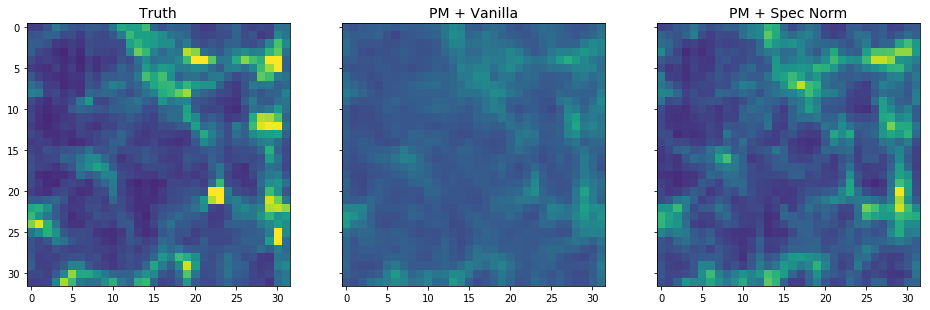

In [85]:
vmin = 0 
vmax = 100

fig, ax = plt.subplots(1, 3, figsize = (16, 5), sharex=True, sharey=True)
fsize = 14
ax[0].imshow(final.sum(axis=0), vmin=vmin, vmax=vmax)
ax[0].set_title('Truth', fontsize=fsize)
ax[1].imshow(finalxreconsfin.sum(axis=0), vmin=vmin, vmax=vmax)
ax[1].set_title('PM + Vanilla', fontsize=fsize)
ax[2].imshow(finalxreconsspecfin.sum(axis=0), vmin=vmin, vmax=vmax)
ax[2].set_title('PM + Spec Norm', fontsize=fsize)



Text(0.5, 1.0, 'PM + Spec Norm')

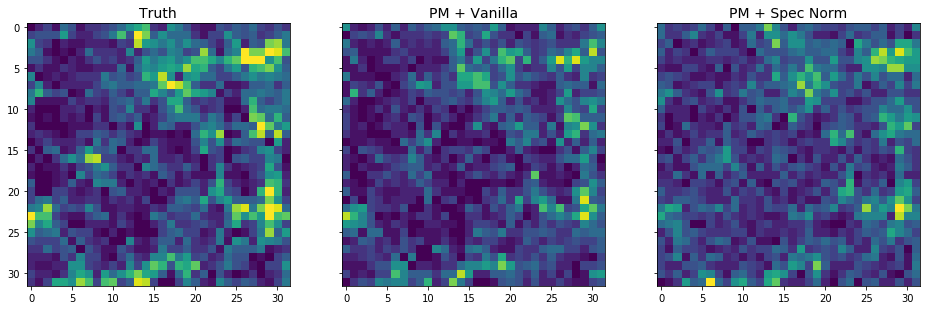

In [104]:
vmin = 0 
vmax = 20

fig, ax = plt.subplots(1, 3, figsize = (16, 5), sharex=True, sharey=True)
fsize = 14
ax[0].imshow(data.sum(axis=0), vmin=vmin, vmax=vmax)
ax[0].set_title('Truth', fontsize=fsize)
ax[1].imshow(samplexreconsfin.sum(axis=0), vmin=vmin, vmax=vmax)
ax[1].set_title('PM + Vanilla', fontsize=fsize)
ax[2].imshow(samplexreconsspecfin.sum(axis=0), vmin=vmin, vmax=vmax)
ax[2].set_title('PM + Spec Norm', fontsize=fsize)



In [176]:
# kk, p1 = tools.power(truth+1, boxsize=bs)
# kk, p2 = tools.power(xrecons[0][0]+1, boxsize=bs)
# kk, p3 = tools.power(xreconsspec[0][0]+1, boxsize=bs)
# kk, p12 = tools.power(truth+1, xrecons[0][0]+1, boxsize=bs)
# kk, p13 = tools.power(truth+1, xreconsspec[0][0]+1, boxsize=bs)

# kk, p2all = tools.power(xrecons[0].mean(axis=0)+1, boxsize=bs)
# kk, p3all = tools.power(xreconsspec[0].mean(axis=0)+1, boxsize=bs)
# kk, p12all = tools.power(truth+1, xrecons[0].mean(axis=0)+1, boxsize=bs)
# kk, p13all = tools.power(truth+1, xreconsspec[0].mean(axis=0)+1, boxsize=bs)

# plt.plot(kk, p12/(p1*p2)**.5, 'r', label='Vanilla recon Single')
# plt.plot(kk, p13/(p1*p3)**.5, 'b', label='Spec recon Single')

# plt.plot(kk, p12all/(p1*p2all)**.5, 'g--', label='Vanilla recon Mean')
# plt.plot(kk, p13all/(p1*p3all)**.5, 'c--', label='Spec recon Mean')

# ii = 1
# kk, p1 = tools.power(finsample[ii], boxsize=bs)
# kk, p2 = tools.power(samplelearn, boxsize=bs)
# kk, p3 = tools.power(samplelearnspec, boxsize=bs)
# kk, p4 = tools.power(samplelearnfin, boxsize=bs)
# kk, p12 = tools.power(finsample[ii], samplelearn, boxsize=bs)
# kk, p13 = tools.power(finsample[ii], samplelearnspec, boxsize=bs)
# kk, p14 = tools.power(finsample[ii], samplelearnfin, boxsize=bs)

# # plt.plot(kk, p12/(p1*p2)**.5, 'k', label='samplelearn Vanilla')
# # plt.plot(kk, p13/(p1*p3)**.5, 'k--', label='samplelearn Spec')
# # plt.plot(kk, p14/(p1*p4)**.5, 'k:', label='samplelearn Vanilla Fin')


# plt.xscale('log')
# plt.xlabel('k (h/Mpc)', fontsize=13)
# plt.ylabel('r$_c$', fontsize=13)
# plt.legend(fontsize=13)

# plt.suptitle('Compare mean recon vs single recon')

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


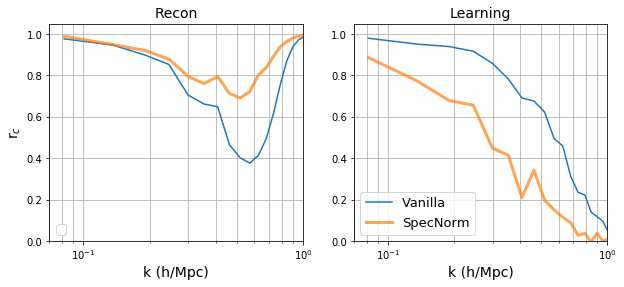

In [103]:
plt.figure(figsize = (10, 4))


kk, p1 = tools.power(truth+1, boxsize=bs)
kk, p4 = tools.power(xreconsfin[0]+1, boxsize=bs)
kk, p5 = tools.power(xreconsspecfin[0]+1, boxsize=bs)

kk, p14 = tools.power(truth+1, xreconsfin[0]+1, boxsize=bs)
kk, p15 = tools.power(truth+1, xreconsspecfin[0]+1, boxsize=bs)

ax1 = plt.subplot(1, 2, 1)
plt.plot(kk, p14/(p1*p4)**.5, 'C0', label='', lw=1.5)
plt.plot(kk, p15/(p1*p5)**.5, 'C1-', label='', lw=3, alpha=0.7)

kk, p1 = tools.power(finsample[testid], boxsize=bs)
kk, p4 = tools.power(samplelearnfin, boxsize=bs)
kk, p5 = tools.power(samplelearnspecfin, boxsize=bs)
kk, p14 = tools.power(finsample[testid], samplelearnfin, boxsize=bs)
kk, p15 = tools.power(finsample[testid], samplelearnspecfin, boxsize=bs)

ax2 = plt.subplot(1, 2, 2)
plt.plot(kk, p14/(p1*p4)**.5, 'C0', label='Vanilla', lw=1.5)
plt.plot(kk, p15/(p1*p5)**.5, 'C1-', label='SpecNorm', lw=3, alpha=0.7)


for axis in [ax1, ax2]:
    axis.set_xscale('log')
    axis.set_xlabel('k (h/Mpc)', fontsize=14)
    axis.set_ylim(0, 1.05)
    axis.grid(which='both')
    axis.set_xlim(0.07, 1)
    axis.legend(fontsize=13)

ax1.set_ylabel('r$_c$', fontsize=14)
ax1.set_title('Recon', fontsize=14)
ax2.set_title('Learning', fontsize=14)
plt.show()